In [1]:
import findspark
findspark.init()
import pyspark, os, csv
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, max, min, substring_index, avg, expr
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
#Create Spark Session
spark = SparkSession.builder.appName("FlubyRegion").getOrCreate()

In [3]:
#directories paths
root_dir = "flu_region"
data_dir = "data"
maps_dir = f"{root_dir}/maps"
pmaps_dir = f"{root_dir}/pred_maps"
fs_dir = f"{root_dir}/pred_by_dates"

In [4]:
#Divide Flu-by-Region into Flu-by-County
filecheck1 = f"{root_dir}/flu_by_county.csv"
if not os.path.isfile(filecheck1):
    fbc_dict = {
    "Bay Area": ["01675839" , "01675903", "00277285", "00277292", "00277302", "00277305" , "00277307",  "00277308" , "00277312", "01657246"],
    "Central": ["01675885", "00277274", "01804637", "00277280", "00277284", "00277286", "00277288", "00277290", "00277291", "00277299", "00277303", "00277314", "00277318", "00277319"],
    "Lower Southern" : ["00277277", "00277294", "00277297", "00277300", "00277301"],
    "Northern" : ["01675840", "01675841", "01675842", "01675902", "01682074", "00277273", "00277275", "01681908", "00277281", "01693324", "00277287", "00277289", "01682927", "00277295", "00277296",  "00277298", "01682610", "00277310", "00277311", "00277315", "01692767", "00277317", "00277321", "00277322"],
    "Upper Southern" : ["02054176", "00277283", "00277304", "00277306", "00277320"]
    }

    df = pd.read_csv(f"{data_dir}/flu-ili-byregion-fluseason.csv")
    # Create an empty list to store new dataframes
    new_dfs = []

    # Loop through each row in the original DataFrame
    for _, row in df.iterrows():
        x_value = row["region"]
        values_to_replace = fbc_dict.get(x_value, [x_value])

        # Create new dataframes for each value in values_to_replace
        for new_x_value in values_to_replace:
            new_df = row.copy().to_frame().T  # Create a new DataFrame with one row
            new_df["region"] = new_x_value
            new_dfs.append(new_df)

    # Concatenate the list of dataframes into a single dataframe
    new_df = pd.concat(new_dfs, ignore_index=True)

    # Write the modified DataFrame to a CSV file
    new_df.to_csv(f"{root_dir}/flu_by_county.csv", index=False)

df = spark.read.csv(f"{root_dir}/flu_by_county.csv", header=True, inferSchema=True)
df.show()

+---------+---------+----------+----------+---------+-------------------+-----------+--------------------------+
|   season|date_code|weekending|    region|Total_ILI|Total_Patients_Seen|Percent_ILI|Number_Providers_Reporting|
+---------+---------+----------+----------+---------+-------------------+-----------+--------------------------+
|2001-2002|   200140| 10/6/2001|  01675839|        3|                135|       2.22|                         2|
|2001-2002|   200140| 10/6/2001|  01675903|        3|                135|       2.22|                         2|
|2001-2002|   200140| 10/6/2001|  00277285|        3|                135|       2.22|                         2|
|2001-2002|   200140| 10/6/2001|  00277292|        3|                135|       2.22|                         2|
|2001-2002|   200140| 10/6/2001|  00277302|        3|                135|       2.22|                         2|
|2001-2002|   200140| 10/6/2001|  00277305|        3|                135|       2.22|           

In [5]:
#Divide data into separate files by date
filecheck2 = f"{root_dir}/flu_by_dates"
if not os.listdir(filecheck2):
    df = spark.read.csv(f"{root_dir}/flu_by_county.csv", header=True, inferSchema=True)
    group_column = "date_code"
    distinct_values = [str(row[group_column]) for row in df.select(group_column).distinct().collect()]

    # Group by the column and write each group to a separate file
    for value in distinct_values:
        group_df = df.filter(col(group_column) == value)
        output_path = f"{filecheck2}/{value}.csv"
        pandas_df = group_df.toPandas()
        pandas_df.to_csv(output_path, header=True, index=False)


In [6]:
# Generate Heatmaps of Observed Data
if not os.listdir(maps_dir):
    ca_map = gpd.read_file(f"data/CA_Counties/CA_Counties_TIGER2016.shp")
    
    # List all csv files
    csv_files = [filename for filename in os.listdir(filecheck2) if filename.endswith(".csv")]

    # Iterate through the subdirectories and read CSV files in each subdirectory
    for csv_file in csv_files:
        
        csv_file_path = os.path.join(filecheck2, csv_file)
        df = pd.read_csv(csv_file_path)

        # Calculate the maximum and minimum values in the "Total_ILI" column
        max_value = df["Total_ILI"].max()
        min_value = df["Total_ILI"].min()

        #Merge files
        mapf = "COUNTYNS"
        statf = "region"
        map_and_stats = ca_map.merge(df, left_on=mapf, right_on=statf)

        #plot map
        fig, ax = plt.subplots(1, figsize=(8, 8))
        plt.xticks(rotation=90)
        map_and_stats.plot(column="Total_ILI", cmap="Reds", linewidth=0.4, ax=ax, edgecolor=".4")
        title_column = "weekending"
        title_value = df[title_column].iloc[0]
        plt.title(f"Total IRI for Week of {title_value}")
        bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=min_value, vmax=max_value))
        bar_info._A = []
        cbar = fig.colorbar(bar_info)

        # Save the map as an image file in the maps directory
        output_file = os.path.join(maps_dir, os.path.splitext(csv_file)[0] + ".png")
        plt.savefig(output_file, dpi=300)

        # Close the figure to release memory
        plt.close(fig)

In [7]:
df = spark.read.csv(f"{root_dir}/flu_by_county.csv", header=True, inferSchema=True)
df = df.filter(df["region"] != "California")
dd = df.toPandas()
dd['weekending'] = pd.to_datetime( dd['weekending'], format='%m/%d/%Y')
dd.sort_values('weekending', inplace=True)
dd["region"] = dd["region"].astype(int)
dd.to_csv(f"{root_dir}/flu_ordered.csv", header=True, index=False)

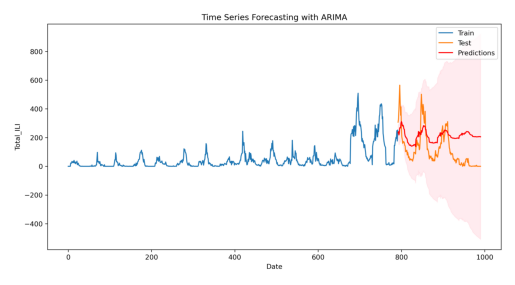

In [14]:
#Visualize Predictions of a Given Region
unique = 277280
png_path = f'{root_dir}/region_{unique}_prediction_image.png'
if not os.path.isfile(png_path):
    df = spark.read.csv(F"{root_dir}/flu_ordered.csv", header=True, inferSchema=True)
    distinct_values = df.select("region").distinct().collect()
    unique_values = [row["region"] for row in distinct_values]
    ddf = df.filter(df["region"] == unique)
    ddf = ddf.toPandas()

    # Split the data into training and testing sets
    train_size = int(len(ddf) * 0.8)
    train_data, test_data = ddf[:train_size], ddf[train_size:]

    # Perform auto ARIMA model selection
    model = auto_arima(train_data['Total_ILI'], seasonal=True, m=52)
    model.fit(train_data['Total_ILI'])
    forecast, conf_int = model.predict(n_periods=len(test_data), return_conf_int=True)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(test_data['Total_ILI'], forecast)
    print(f"Mean Squared Error (MSE): {mse}")

    # Calculate Root Mean Squared Error (RMSE)
    rmse = sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Visualize the observed data and predictions
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data['Total_ILI'], label="Train")
    plt.plot(test_data.index, test_data['Total_ILI'], label="Test")
    plt.plot(test_data.index, forecast, label="Predictions", color="red")
    plt.fill_between(test_data.index, conf_int[:, 0], conf_int[:, 1], color="pink", alpha=0.3)
    plt.xlabel("Date")
    plt.ylabel("Total_ILI")
    plt.title("Time Series Forecasting with ARIMA")
    plt.legend()
    plt.savefig(png_path, dpi=300, bbox_inches='tight')
else:
    img = mpimg.imread(png_path)
    plt.axis('off')
    plt.imshow(img)


In [9]:
#Forecast Predictions for all counties and place all into csv file
filecheck3 = f"{root_dir}/predictions.csv"
if not os.path.isfile(filecheck3):
    df = spark.read.csv(F"{root_dir}/flu_ordered.csv", header=True, inferSchema=True)
    distinct_values = df.select("region").distinct().collect()
    unique_values = [row["region"] for row in distinct_values]

    forecasts = []
    for unique in unique_values:
        dd = df.filter(df["region"] == unique)
        dd = dd.toPandas()
        data_size = int(len(dd)*0.8)
        fore_size = int(len(dd)*0.15)
        ddf = dd[data_size:]
        ddf.set_index('weekending', inplace=True)
        ddd = dd[:data_size]
        ddd.set_index('weekending', inplace=True)
        # print(ddf)

        # Perform auto ARIMA model selection
        model = auto_arima(ddf['Total_ILI'], seasonal=True, m=52)
        model.fit(ddf['Total_ILI'])
        forecast, conf_int = model.predict(n_periods=fore_size, return_conf_int=True)
        framecast = pd.DataFrame({'Total_ILI':forecast})
        new_col = [unique]
        framecast["region"] = new_col * (len(framecast) // len(new_col))
        forecasts.append(framecast)

    fores = pd.concat(forecasts, ignore_index=False)
    fores.to_csv(f"{root_dir}/predictions.csv", index_label="weekending")

In [10]:
#Divide data into separate files by date
filecheck4 = f"{root_dir}/pred_by_dates"
if not os.listdir(filecheck4):
    df = spark.read.csv(f"{root_dir}/predictions.csv", header=True, inferSchema=True)
    group_column = "weekending"
    distinct_values = [str(row[group_column]) for row in df.select(group_column).distinct().collect()]

    # Group by the column and write each group to a separate file
    for value in distinct_values:
        group_df = df.filter(col(group_column) == value)
        output_path = f"{filecheck3}/{value}.csv"
        pandas_df = group_df.toPandas()
        pandas_df.to_csv(output_path, header=True, index=False)


In [11]:
# Generate Heatmaps for Predicted Data
if not os.listdir(pmaps_dir):
    ca_map = gpd.read_file(f"data/CA_Counties/CA_Counties_TIGER2016.shp")
    csv_files = [filename for filename in os.listdir(fs_dir) if filename.endswith(".csv")]

    # Iterate through the subdirectories and read CSV files in each subdirectory
    for csv_file in csv_files:
        csv_file_path = os.path.join(fs_dir, csv_file)
        df = pd.read_csv(csv_file_path)

        # Calculate the maximum and minimum values in the "Total_ILI" column
        max_value = df["Total_ILI"].max()
        min_value = df["Total_ILI"].min()
        
        #Merge files
        ca_map["COUNTYNS"] = ca_map["COUNTYNS"].astype(int)
        mapf = "COUNTYNS"
        statf = "region"
        map_and_stats = ca_map.merge(df, left_on=mapf, right_on=statf)

        #plot map
        fig, ax = plt.subplots(1, figsize=(8, 8))
        plt.xticks(rotation=90)
        map_and_stats.plot(column="Total_ILI", cmap="Reds", linewidth=0.4, ax=ax, edgecolor=".4")
        title_column = "weekending"
        title_value = df[title_column].iloc[0]
        plt.title(f"Total IRI for Week of {title_value}")
        bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=min_value, vmax=max_value))
        bar_info._A = []
        cbar = fig.colorbar(bar_info)
        
        # Save the map as an image file in the pred_maps directory
        output_file = os.path.join(pmaps_dir, os.path.splitext(csv_file)[0] + ".png")
        plt.savefig(output_file, dpi=300)
        plt.close(fig)

In [12]:
spark.stop()